# CubicGalileonEmu

> GP emulator for boost factor in cubic Galileon gravity model

Modified Gravity emulator for boost in the dark matter power spectra

## Install

(not installable yet)
```sh
pip install CubicGalileonEmu
```

## Basic rundown

### A few imports 

In [ ]:
from CubicGalileonEmu.load import *
from CubicGalileonEmu.viz import *
from CubicGalileonEmu.pca import *
from CubicGalileonEmu.gp import *
from CubicGalileonEmu.emu import *

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

### Loading files

In [ ]:
Bk_all, k_all, z_all = load_boost_training()
p_all = load_params()

exclude = 35
Bk_all = np.delete(Bk_all, exclude, axis=0)
p_all = np.delete(p_all, exclude, axis=0)

### A few plotting routines

#### Experimental design

/home/nramachandra/Projects/MG_emu/Codes/CubicGalileonEmu/CubicGalileonEmu/viz.py:63: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  scatter_matrix = pd.plotting.scatter_matrix(df,


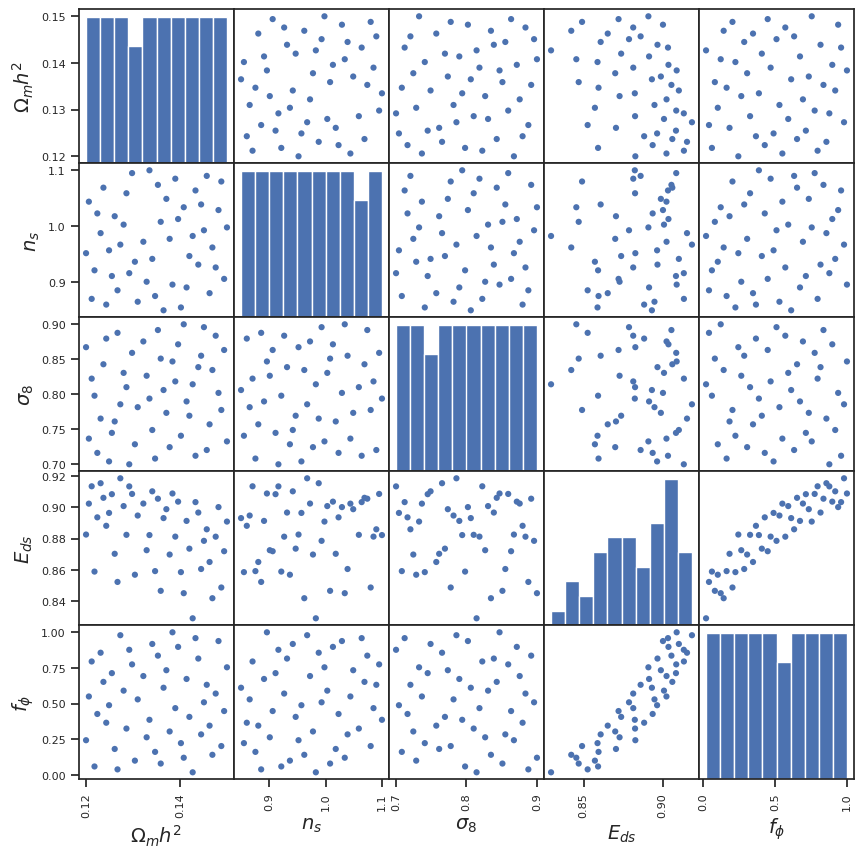

In [ ]:
df_train_a = pd.DataFrame(p_all, columns=PARAM_NAME)
colors = ['b']*p_all.shape[0]
# colors = ['b']*num_sims + ['r']*num_sims_test
plot_scatter_matrix(df_train_a, colors);

#### Boost metrics colored by cosmology parameters

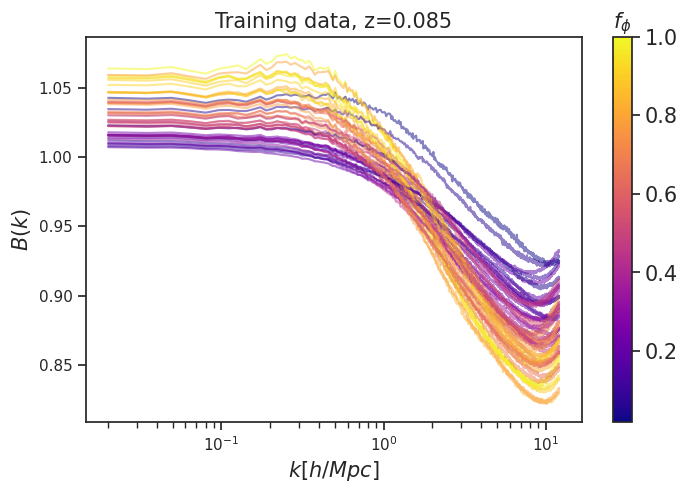

In [ ]:
color_by_index = 4
z_index = 0

plot_lines_with_param_color(p_all[:, color_by_index], 
                            k_all, 
                            Bk_all[:, z_index, :], 
                            'Training data, z=' + str(z_all[z_index]), 
                            r'$k [h/Mpc]$', 
                            r'$B(k)$', 
                            PARAM_NAME[color_by_index]);

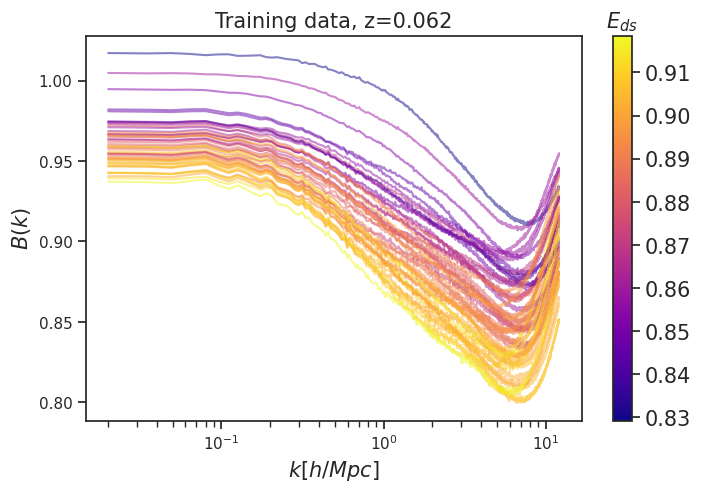

In [ ]:
color_by_index = 3
z_index = 21

plot_lines_with_param_color(p_all[:, color_by_index], 
                            k_all, 
                            Bk_all[:, z_index, :], 
                            'Training data, z=' + str(z_all[z_index]), 
                            r'$k [h/Mpc]$', 
                            r'$B(k)$', 
                            PARAM_NAME[color_by_index]);

In [ ]:
#| hide
# import numpy as np
# np.where(np.isfinite(p_all) == False)

In [ ]:
# do_pca

### Training involves: PCA, GP fitting.  

In [ ]:
z_index = 0
y_vals = Bk_all[:, z_index, :]
# y_ind = np.arange(0, y_vals.shape[1])
y_ind = k_all
sepia_data = sepia_data_format(p_all, y_vals, y_ind)
print(sepia_data)

sepia_model = do_pca(sepia_data, exp_variance=0.95)
sepia_model = do_gp_train(sepia_model, '../CubicGalileonEmu/model/multivariate_model')

This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 768
m  =    49 (number of simulated data)
p  =     1 (number of inputs)
q  =     5 (number of additional simulation inputs)
pu NOT SET (transformed response dimension); call method create_K_basis 

Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.32it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.99318519 0.67046927]
 [0.55861091 0.49280278]
 [0.05400691 0.06021993]
 [0.20980535 0.1692818 ]
 [1.04182629 0.1608188 ]
 [0.03483218 0.35369988]]
lamUz
[[0.78639732 0.62545433]]
lamWs
[[2318.27493059 4425.48252737]]
lamWOs
[[5.19226355]]


MCMC sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.76it/s]

Model saved to ../CubicGalileonEmu/model/multivariate_model.pkl


/home/nramachandra/Projects/Hydro_runs/Sepia_trials/SEPIA/sepia/SepiaPlot.py:156: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=plot_idx,y=samples_dict[k][plot_idx,j], palette="tab10", linewidth=.75, ax = axs[i],
/home/nramachandra/Projects/Hydro_runs/Sepia_trials/SEPIA/sepia/SepiaPlot.py:156: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=plot_idx,y=samples_dict[k][plot_idx,j], palette="tab10", linewidth=.75, ax = axs[i],
/home/nramachandra/Projects/Hydro_runs/Sepia_trials/SEPIA/sepia/SepiaPlot.py:156: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=plot_idx,y=samples_dict[k][plot_idx,j], palette="tab10", linewidth=.75, ax = axs[i],
/home/nramachandra/Projects/Hydro_runs/Sepia_trials/SEPIA/sepia/SepiaPlot.py:156: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=plot_idx,y=samples_dict[k][plot_idx,j], p

No thetas to plot


/home/nramachandra/Projects/Hydro_runs/Sepia_trials/SEPIA/sepia/SepiaPlot.py:156: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=plot_idx,y=samples_dict[k][plot_idx,j], palette="tab10", linewidth=.75, ax = axs[i],
/home/nramachandra/Projects/Hydro_runs/Sepia_trials/SEPIA/sepia/SepiaPlot.py:156: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=plot_idx,y=samples_dict[k][plot_idx,j], palette="tab10", linewidth=.75, ax = axs[i],
/home/nramachandra/Projects/Hydro_runs/Sepia_trials/SEPIA/sepia/SepiaPlot.py:156: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=plot_idx,y=samples_dict[k][plot_idx,j], palette="tab10", linewidth=.75, ax = axs[i],
/home/nramachandra/Projects/Hydro_runs/Sepia_trials/SEPIA/sepia/SepiaPlot.py:156: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=plot_idx,y=samples_dict[k][plot_idx,j], p

(None, <Figure size 1000x750 with 5 Axes>)

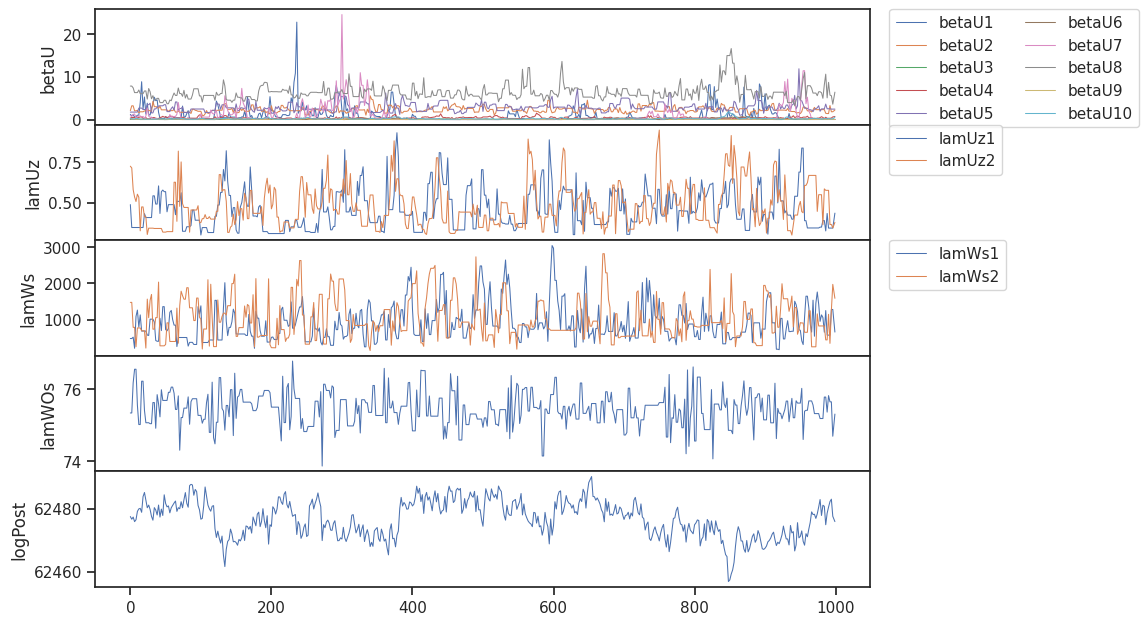

In [ ]:
plot_train_diagnostics(sepia_model)

In [ ]:
# save_model = False
# load_model = True



# import os
# model_file = 'multivariate_model'

# if load_model and os.path.isfile(model_file+'.pkl'):
#     sepia_model.restore_model_info(model_file)
# else:
#     sepia_model.tune_step_sizes(50, 20, update_vals=True)
#     sepia_model.do_mcmc(1000)
#     if save_model: sepia_model.save_model_info(model_file)

In [ ]:
sepia_model = gp_load(sepia_model, '../CubicGalileonEmu/model/multivariate_model')

In [ ]:
test_indices = [0, 1, 3, 4, 5]
input_params= p_all[test_indices]
target_vals = Bk_all[:, z_index, :][test_indices]

pred_mean, pred_quant = emulate(sepia_model, input_params)

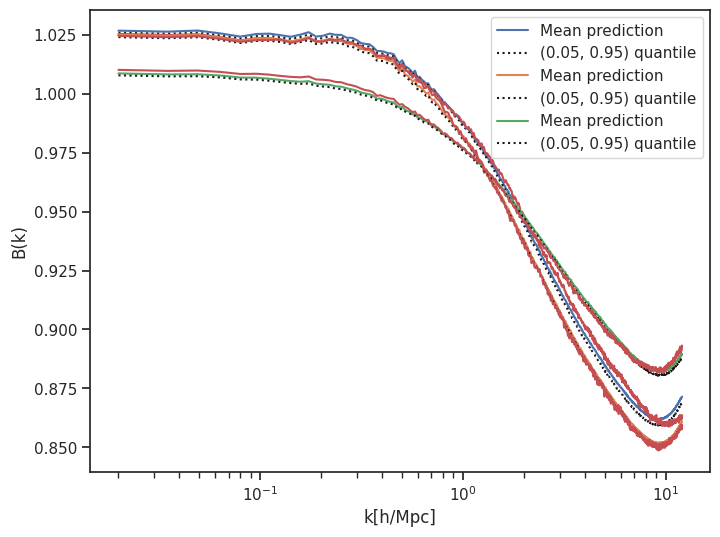

In [ ]:
f, a = plt.subplots(1, 1, figsize=(8, 6))

for one_index in range(3):
    # one_index = 0
    a.plot(k_all, pred_mean[:, one_index], label='Mean prediction')
    a.plot(k_all, pred_quant[:, one_index, 0],'k:', label='(0.05, 0.95) quantile')
    a.plot(k_all, target_vals[one_index], 'r')
a.set_xlabel('k[h/Mpc]')
a.set_ylabel('B(k)')
a.set_xscale('log')
plt.legend()
plt.show()

[0.12       0.85       0.7        0.82928725 0.02041   ]
[0.15       1.1        0.9        0.91853348 1.        ]


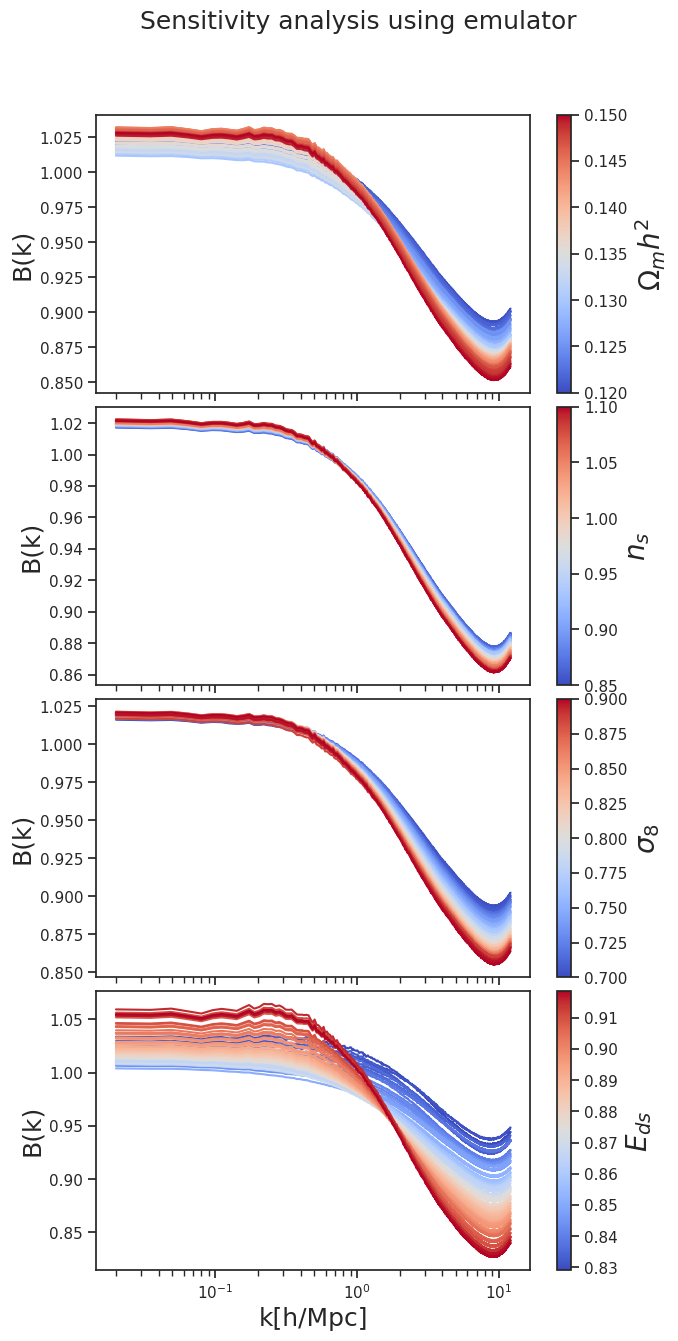

In [ ]:
from matplotlib import ticker
from itertools import cycle
import matplotlib.colors as mcolors
import matplotlib.cm as cm


color_by_index = 0
colorparams = p_all[:, color_by_index]
# colorparams = X_test_transformed1[:, color_by_index]
colormap = cm.Dark2
normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

allMax = np.max(p_all, axis = 0)
allMin = np.min(p_all, axis = 0)
allMean = np.mean(p_all, axis = 0)

numPlots = 84

fig, ax = plt.subplots(4,1, figsize = (7, 15), sharex='col')

plt.subplots_adjust(wspace=0.25)
plt.subplots_adjust(hspace=0.05)
plt.suptitle('Sensitivity analysis using emulator', fontsize=18, y=0.95)

print(allMin)
print(allMax)


for paramNo in range(4):
        para_range = np.linspace(allMin[paramNo], allMax[paramNo], numPlots)        
        # colorList = plt.cm.coolwarm(np.linspace(0,1,numPlots))
        
        colormap = cm.coolwarm
        normalize = mcolors.Normalize(vmin=np.min(allMin[paramNo]), vmax=allMax[paramNo])

        for plotID in range(numPlots):
                para_plot = np.copy(allMean)
                para_plot[paramNo] = para_range[plotID]  #### allMean gets changed everytime!!

                color = colormap(normalize(para_plot[paramNo]))

                gsmf_decoded, _ = emulate(sepia_model, para_plot)
                
                lineObj = ax[paramNo].plot(k_all, gsmf_decoded, lw= 1.5, color = color) 

                # ax[paramNo].set_yscale('log')
                ax[paramNo].set_xscale('log')
                ax[paramNo].set_ylabel('B(k)', fontsize=18)
                ax[paramNo].set_yticks([], minor = True)
                            
            
        # Colorbar setup
        s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
        s_map.set_array(colorparams)

        # If color parameters is a linspace, we can set boundaries in this way
        halfdist = (colorparams[1] - colorparams[0])/2.0
        boundaries = np.linspace(colorparams[0] - halfdist, colorparams[-1] + halfdist, len(colorparams) + 1)

        cbar = fig.colorbar(s_map, spacing='proportional', ax=ax[paramNo])

        cbarlabel = PARAM_NAME[paramNo]
        cbar.set_label(cbarlabel, fontsize=20)
           
ax[paramNo].set_xlabel('k[h/Mpc]', fontsize=18)
plt.show()